In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pystan

In [2]:
K = 2
N = 500
theta = np.r_[0.3, 0.7]
mu = np.r_[-1, 2]
sigma = np.r_[1, 5]
n = (N * theta).astype(int)
y = np.hstack(
    [np.random.normal(loc, scale, size=size) for loc, scale, size in zip(mu, sigma, n)]
)

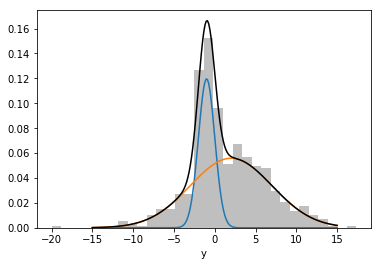

In [3]:
plt.hist(y, color='grey', alpha=.5, bins=32, density=True);
plt.xlabel('y');

x = np.linspace(-15,15,201)
s = 0
for t, loc, scale, size in zip(theta, mu, sigma, n):
    comp = sp.stats.norm(loc, scale).pdf(x)*t
    s += comp
    plt.plot(x, comp)
plt.plot(x, s, c='k')

In [4]:
%%time
stan_model = """
data {
  int<lower=1> K;          // number of mixture components
  int<lower=1> N;          // number of data points
  real y[N];               // observations
}
parameters {
  simplex[K] theta;          // mixing proportions
  vector[K] mu;             // locations of mixture components
  vector<lower=0>[K] sigma;  // scales of mixture components
}
model {
  vector[K] log_theta = log(theta);  // cache log calculation
  sigma ~ lognormal(0, 2);
  mu ~ normal(0, 10);
  for (n in 1:N) {
    vector[K] lps = log_theta;
    for (k in 1:K)
    lps[k] += normal_lpdf(y[n] | mu[k], sigma[k]);
    target += log_sum_exp(lps);
  }
}
"""
model1d = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_46dd26dfb3e9fdd16ba31affe58a64b4 NOW.
/home/soh/.conda/envs/matrix/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpdvhp_5hs/stanfit4anon_model_46dd26dfb3e9fdd16ba31affe58a64b4_5948726869431033333.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


CPU times: user 746 ms, sys: 421 ms, total: 1.17 s
Wall time: 1min


In [5]:
data = dict(
    K=2,
    N=N,
    y=y
)
def init():
    return dict(
        theta=[0.5, 0.5],
        mu = [0, 2],
        sigma = [5, 5]
    )
r = model1d.sampling(data=data, init=init)

In [6]:
r

Inference for Stan model: anon_model_46dd26dfb3e9fdd16ba31affe58a64b4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]   0.26  6.2e-4   0.04   0.19   0.23   0.26   0.28   0.33   3271    1.0
theta[2]   0.74  6.2e-4   0.04   0.67   0.72   0.74   0.77   0.81   3271    1.0
mu[1]      -1.1  2.3e-3   0.13  -1.35  -1.19  -1.11  -1.01  -0.84   3417    1.0
mu[2]      2.11  4.6e-3   0.29   1.55   1.92   2.11   2.31    2.7   3974    1.0
sigma[1]   0.82  2.2e-3   0.12    0.6   0.73   0.82    0.9   1.08   3171    1.0
sigma[2]   5.08  3.4e-3    0.2   4.71   4.93   5.07   5.22   5.49   3622    1.0
lp__      -1430    0.04   1.61  -1434  -1431  -1430  -1429  -1428   1996    1.0

Samples were drawn using NUTS at Tue Jul  9 16:07:43 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reductio

In [72]:
K = 2
N = 500
theta = np.r_[0.95, 0.05]
mu = np.array([[-1, 2], [3, 0]])
sigma = np.stack([np.eye(2), np.eye(2)*9])
n = (N * theta).astype(int)
y = []
for loc, scale, size in zip(mu, sigma, n):
    cy = np.random.multivariate_normal(loc, scale, size=size)
    print(np.cov(cy.T), np.mean(cy, axis=0))
    y.append(cy)
y = np.vstack(y)

[[ 0.8657162  -0.00111545]
 [-0.00111545  1.00103526]] [-1.01072444  2.00541312]
[[5.41398063 0.21292483]
 [0.21292483 9.59244857]] [ 2.98355395 -0.09189563]


In [73]:
n

array([475,  25])

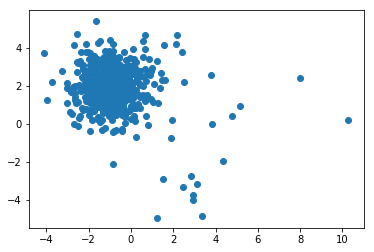

In [74]:
plt.scatter(y.T[0], y.T[1]);

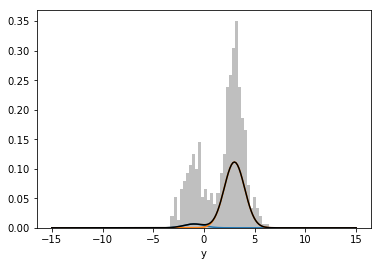

In [8]:
plt.hist(y.T[0], color='grey', alpha=.5, bins=32, density=True);
plt.xlabel('y');

x = np.linspace(-15,15,201)
x = np.c_[x, np.zeros(201)]
s = 0
for t, loc, scale, size in zip(theta, mu, sigma, n):
    comp = sp.stats.multivariate_normal(loc, scale).pdf(x)*t
    s += comp
    plt.plot(x.T[0], comp)
plt.plot(x.T[0], s, c='k')

In [40]:
stan_model = """
data {
  int<lower=1> D;          // number of dimensions
  int<lower=1> K;          // number of mixture components
  int<lower=1> N;          // number of data points
  vector[D] y[N];               // observations
}
parameters {
  simplex[K] theta;             // mixing proportions
  vector[D] mu[K];             // locations of mixture components
  cholesky_factor_corr[D] L[K];  
}
model {
  vector[K] log_theta = log(theta);  // cache log calculation
  for (k in 1:K) {
    mu[k] ~ normal(0, 10);
    L[k] ~ lkj_corr_cholesky(2);
  }
  
  for (n in 1:N) {
    vector[K] lps = log_theta;
    for (k in 1:K)
      lps[k] += multi_normal_cholesky_lpdf(y[n] | mu[k], L[k]);
    target += log_sum_exp(lps);
  }
}
generated quantities {
  vector[K] prob[N];
  for (n in 1:N) {
      for (k in 1:K) {
        prob[n][k] = theta[k] * exp(multi_normal_cholesky_lpdf(y[n] | mu[k], L[k]));
      }
  }
}
"""
modeldd = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_947f30a84d454a04ecb52e9e58fc4d24 NOW.
/home/soh/.conda/envs/matrix/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp8xmc5tk4/stanfit4anon_model_947f30a84d454a04ecb52e9e58fc4d24_731483330699587950.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [76]:
data = dict(
    K=2,
    D=2,
    N=N,
    y=y
)
def init():
    return dict(
        theta=[0.9, 0.1],
        mu = np.array([[-1, 2],[0,3]]).T,
#         mu = np.array([[-1, 1],[0, 2]]).T,
        sigma = np.stack([np.eye(2), np.eye(2)*25])
    )
r = modeldd.sampling(data=data, init=init)# iter=10000)

In [77]:
r


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_947f30a84d454a04ecb52e9e58fc4d24.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]     0.97  9.8e-5 7.6e-3   0.95   0.96   0.97   0.97   0.98   5971    1.0
theta[2]     0.03  9.8e-5 7.6e-3   0.02   0.03   0.03   0.04   0.05   5971    1.0
mu[1,1]     -0.95  6.0e-4   0.05  -1.04  -0.98  -0.95  -0.92  -0.86   5872    1.0
mu[2,1]      3.99  3.8e-3   0.28   3.45    3.8   3.98   4.18   4.52   5386    1.0
mu[1,2]      2.01  6.1e-4   0.05   1.92   1.98   2.01   2.05    2.1   5794    1.0
mu[2,2]     -1.93  3.7e-3   0.27  -2.45  -2.12  -1.93  -1.74  -1.39   5425    1.0
L[1,1,1]      1.0     nan    0.0    1.0    1.0    1.0    1.0    1.0    nan    nan
L[2,1,1]      1.0     nan    0.0    1.0    1.0    1.0    1.0    1.0    nan    nan
L[1,2,1]     0.04  5.7e-4   0.04 

In [78]:
r['prob'].shape

(4000, 500, 2)

In [79]:
renorm = r['prob'][:,:,:]/r['prob'][:,:,:].sum(axis=2)[:,:,None]

In [80]:
n

array([475,  25])

In [81]:
(np.mean(renorm[:,:,1], axis=0)>0.1).sum()

15

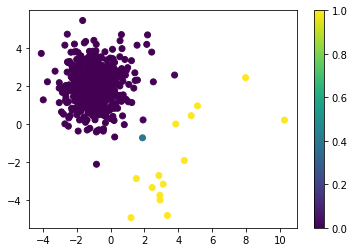

In [82]:
col = plt.scatter(y.T[0], y.T[1], c=np.mean(renorm[:,:,1], axis=0))
plt.colorbar(col);